In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from IPython.core.display import display
from tqdm import tqdm_notebook as tqdm
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
with open('tmp.pkl', 'rb') as f:
    x_train, y_train, cv = pickle.load(f)

In [11]:
df = (x_train.shape[0] - x_train.count()).reset_index()

In [17]:
a = df[df[0] != 0]
a.to_csv('num_na.csv', index=False)

In [19]:
x_train[['o_user_id', 'o_product_id']].to_csv('aaa.csv', index=False)

In [23]:
with open('train_best.pkl', 'wb') as f:
    pickle.dump((x_train, y_train, cv), f, -1)

In [26]:
with open('aaa.pkl', 'wb') as f:
    pickle.dump(x_train.columns.values, f, -1)

In [25]:
x_train.shape

(8474661, 196)

In [11]:
df = pd.read_csv('../input/df_prior.csv', usecols=['user_id', 'product_id']).drop_duplicates()

In [18]:
prd = sorted(df.product_id.values.tolist())
tmp = df.head(10000).groupby('user_id').apply(lambda x: ''.join(['1' if p in x.product_id else'0' for p in prd]))

KeyboardInterrupt: 

In [20]:
prd = sorted(df.product_id.values.tolist())
map_prd = {prd[i]: i for i in range(len(prd))}
def ttt(x):
    a = np.zeros(len(prd), dtype=int)
    for i in x.product_id.values:
        a[map_prd[i]] = 1
    return ''.join(map(str, a))
df.head(10000).groupby('user_id').apply(ttt)

KeyboardInterrupt: 

In [21]:
tmp = df.groupby('user_id').apply(lambda x: x.product_id.values.tolist())

In [22]:
tmp

user_id
1         [196, 12427, 10258, 25133, 10326, 17122, 41787...
2         [49451, 32792, 32139, 34688, 36735, 37646, 228...
3         [38596, 21903, 248, 40604, 8021, 17668, 21137,...
4         [22199, 25146, 1200, 17769, 43704, 37646, 1186...
5         [27344, 24535, 43693, 40706, 16168, 21413, 139...
6         [38293, 20323, 40992, 21903, 45007, 11068, 106...
7         [13198, 42803, 8277, 37602, 40852, 4920, 4945,...
8         [21903, 28985, 6473, 39110, 39812, 20920, 3203...
9         [27973, 481, 27966, 33754, 4957, 13351, 40571,...
10        [46979, 47380, 20995, 43014, 15011, 27156, 135...
11        [8230, 30480, 22950, 34551, 44632, 15261, 3303...
12        [13176, 14992, 44422, 11520, 31506, 22959, 712...
13        [27086, 27435, 41480, 31372, 33735, 25134, 430...
14        [40836, 8744, 23803, 46979, 13966, 12429, 3336...
15        [37710, 10441, 12427, 1747, 27839, 196, 14715,...
16        [21903, 41950, 5134, 44359, 28985, 17794, 4070...
17        [7350, 18534, 17762, 4

In [ ]:
prd = sorted(df.product_id.values.tolist())
map_prd = {prd[i]: i for i in range(len(prd))}
def ttt(x):
    a = np.zeros(len(prd), dtype=int)
    idx = [map_prd[i] for i in x]
    a[idx] = 1
    return '{}'.format(a.tolist())

from multiprocessing import Pool

p = Pool()
tmp2 = list(p.map(ttt, tmp.values))
p.close()
p.join()

In [ ]:
df2 = pd.DataFrame()
df2['user_id'] = tmp.index.values
df2['pt'] = tmp2

pp = df2.groupby('user_id')['pt'].count()

In [ ]:
tmp2[0]

In [ ]:
pp.to_csv('user_item_pattern.csv')

In [2]:
df = pd.read_csv('../input/df_prior.csv', usecols=['product_id', 'product_name', 'reordered'])

In [ ]:
def aaa(x):
    ret = re.sub(r'(\(.*?\)|[^a-z^A-Z])', ' ', x.lower()).split()
    return ret
tmp = df['product_name'].apply(aaa)

In [ ]:
#from gensim import models
from gensim import corpora
from gensim.matutils import corpus2csc
def corpus_to_sentences(df):
    p = Pool()
    ret = p.map(_load, enumerate(df.values))
    p.close()
    p.join()
    return ret
dictionary = corpora.Dictionary(tmp)
dictionary.filter_extremes(no_below=2, no_above=1., keep_n=2000000)

In [ ]:
id_corpus = map(dictionary.doc2bow, tmp)
count_mat = corpus2csc(id_corpus).T

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [8]:
model = LogisticRegression(random_state=0)
a = cross_val_score(model, count_mat, df.reordered.values, scoring='roc_auc', n_jobs=4, cv=4)
print(a, a.mean())
#model.fit(count_mat, df.reordered.values)
#pred = model.predict_proba(count_mat)[:, 1]
#roc_auc_score(df.reordered.values, pred)

[ 0.64729733  0.64737234  0.64836356  0.64782562] 0.647714709805


In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(max_depth=3, subsample=0.7, colsample_bytree=0.7, min_child_samples=20, seed=0, n_estimators=1000, learning_rate=0.1, reg_alpha=0.1)
a = cross_val_score(model, count_mat, df.reordered.values, scoring='roc_auc', n_jobs=4, cv=4)
print(a, a.mean())

[ 0.64224429  0.64236127  0.64337611  0.64277664] 0.642689576358


In [ ]:
model = LogisticRegression(random_state=0)
model.fit(count_mat, df.reordered.values)
pred = model.predict_proba(count_mat)[:, 1]
df['pred_logreg'] = pred
print('aaa')

model = BernoulliNB()
model.fit(count_mat, df.reordered.values)
pred = model.predict_proba(count_mat)[:, 1]
df['pred_naive'] = pred
print('bbb')

model = LGBMClassifier(max_depth=3, subsample=0.7, colsample_bytree=0.7, min_child_samples=20, seed=0, n_estimators=1000, learning_rate=0.1, reg_alpha=0.1)
model.fit(count_mat, df.reordered.values)
pred = model.predict_proba(count_mat)[:, 1]
df['pred_gbm'] = pred

In [ ]:
df[['product_id', 'pred_logreg', 'pred_naive', 'pred_gbm']].drop_duplicates().to_csv('word_preds.csv', index=False)

In [30]:
df = pd.read_csv('tmp.csv')
df1 = pd.read_csv('tmp_w_mean.csv')

#(df['194'] - df ['174'] >= 0 & ).to_csv('tmp_use.csv', index=False)
((df['194'] - df ['174'] >= 0) & (df1['194'] - df1['174'] >= 0) & (df1['194'] - df ['194'] >= 0)).to_csv('tmp_use.csv', index=False)

In [31]:
 pd.read_csv('tmp_use.csv', header=None)[0].values.mean()

0.71059149905875363

In [34]:
df["194"].mean()

0.3014265894475296

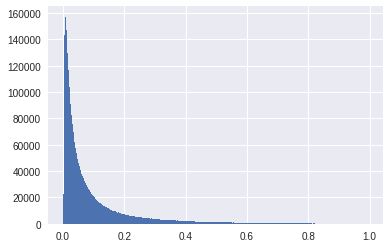

In [8]:
with open('train_cv_tmp.pkl', 'rb') as f:
    pred = pickle.load(f)
pd.Series(pred).hist(bins=1000)

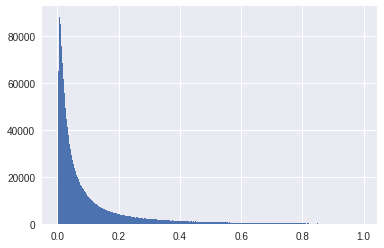

In [9]:
with open('test_tmp.pkl', 'rb') as f:
    pred = pickle.load(f)[:, 1]
pd.Series(pred).hist(bins=1000)

In [2]:
with open('train_cv_pred.pkl', 'rb') as f:
    pred = pickle.load(f)
df = pd.read_csv('train_data_idx.csv', dtype=int)

with open('user_split.pkl', 'rb') as f:
    cv = pickle.load(f)

list_cv = []
user_ids = df['user_id']

for train, test in cv[:1]:
    trn = user_ids.isin(train)
    val = user_ids.isin(test)
    
df_trn = df.loc[trn, :].copy()
df_val = df.loc[val, :].copy()

df_test = pd.read_csv('test_data_idx.csv', dtype=int)

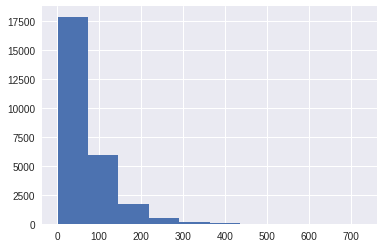

In [3]:
df_val.groupby('user_id')['user_id'].count().hist()

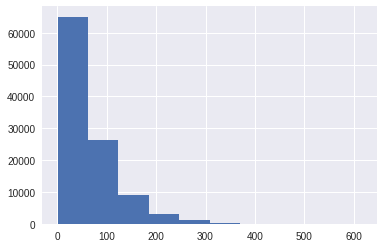

In [4]:
df_trn.groupby('user_id')['user_id'].count().hist()

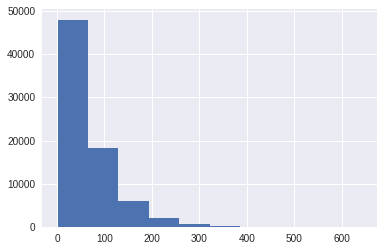

In [5]:
df_test.groupby('user_id')['user_id'].count().hist()

In [8]:
df.sort_values('user_id')

order_id  user_id
484425   1187899        1
484424   1187899        1
484426   1187899        1
484423   1187899        1
484422   1187899        1
484430   1187899        1
484428   1187899        1
484427   1187899        1
484429   1187899        1
484420   1187899        1
484421   1187899        1
606755   1492625        2
606776   1492625        2
606777   1492625        2
606769   1492625        2
606768   1492625        2
606767   1492625        2
606747   1492625        2
606766   1492625        2
606765   1492625        2
606748   1492625        2
606764   1492625        2
606763   1492625        2
606762   1492625        2
606750   1492625        2
606751   1492625        2
606775   1492625        2
606752   1492625        2
606753   1492625        2
606761   1492625        2
...          ...      ...
961402   2371631   206203
961401   2371631   206203
961393   2371631   206203
698110   1716008   206205
698111   1716008   206205
698109   1716008   206205
698108   1716008   206205
698093   1716008   206205
698099   1716008   206205
698107   1716008   206205
698098   1716008   206205
698097   1716008   206205
698101   1716008   206205
698102   1716008   206205
698103   1716008   206205
698104   1716008   206205
698105   1716008   206205
698106   1716008   206205
698094   1716008   206205
698095   1716008   206205
698100   1716008   206205
698096   1716008   206205
111265    272231   206209
111271    272231   206209
111270    272231   206209
111269    272231   206209
111268    272231   206209
111267    272231   206209
111266    272231   206209
111264    272231   206209

[1384617 rows x 2 columns]

In [3]:
df = pd.read_csv("df_train.csv", usecols=['user_id', 'order_id'])
order_products_train_df.groupby('order_id')['user_id'].agg(['count', 'max', 'min'])

KeyError: 'Column not found: user_id'

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [3]:
order_products_train_df = pd.read_csv("../input/order_products__train.csv")
order_products_prior_df = pd.read_csv("../input/order_products__prior.csv")
orders_df = pd.read_csv("../input/orders.csv")
products_df = pd.read_csv("../input/products.csv")
aisles_df = pd.read_csv("../input/aisles.csv")
departments_df = pd.read_csv("../input/departments.csv")

In [28]:
display(orders_df[orders_df['user_id'] == 1])
display(orders_df[orders_df['user_id'] == 3])

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    2539329        1    prior             1          2                  8   
1    2398795        1    prior             2          3                  7   
2     473747        1    prior             3          3                 12   
3    2254736        1    prior             4          4                  7   
4     431534        1    prior             5          4                 15   
5    3367565        1    prior             6          2                  7   
6     550135        1    prior             7          1                  9   
7    3108588        1    prior             8          1                 14   
8    2295261        1    prior             9          1                 16   
9    2550362        1    prior            10          4                  8   
10   1187899        1    train            11          4                  8   

    days_since_prior_order  
0                      NaN  
1                     15.0  
2                     21.0  
3                     29.0  
4                     28.0  
5                     19.0  
6                     20.0  
7                     14.0  
8                      0.0  
9                     30.0  
10                    14.0

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
26   1374495        3    prior             1          1                 14   
27    444309        3    prior             2          3                 19   
28   3002854        3    prior             3          3                 16   
29   2037211        3    prior             4          2                 18   
30   2710558        3    prior             5          0                 17   
31   1972919        3    prior             6          0                 16   
32   1839752        3    prior             7          0                 15   
33   3225766        3    prior             8          0                 17   
34   3160850        3    prior             9          0                 16   
35    676467        3    prior            10          3                 16   
36    521107        3    prior            11          0                 18   
37   1402502        3    prior            12          1                 15   
38   2774568        3     test            13          5                 15   

    days_since_prior_order  
26                     NaN  
27                     9.0  
28                    21.0  
29                    20.0  
30                    12.0  
31                     7.0  
32                     7.0  
33                     7.0  
34                     7.0  
35                    17.0  
36                    11.0  
37                    15.0  
38                    11.0

In [7]:
products_df.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [8]:
aisles_df.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [9]:
departments_df.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [10]:
order_products_train_df.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [11]:
order_products_prior_df.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [4]:
df_train = pd.merge(order_products_train_df, orders_df, how='left', on='order_id')
df_train = pd.merge(df_train, products_df, how='left', on='product_id')
df_train = pd.merge(df_train, aisles_df, how='left', on='aisle_id')
df_train = pd.merge(df_train, departments_df, how='left', on='department_id')
print(df_train.shape)
df_train.to_csv('../input/df_train.csv', index=False)
df_train.head()

(1384617, 15)


order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         1       49302                  1          1   112108    train   
1         1       11109                  2          1   112108    train   
2         1       10246                  3          0   112108    train   
3         1       49683                  4          0   112108    train   
4         1       43633                  5          1   112108    train   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             4          4                 10                     9.0   
1             4          4                 10                     9.0   
2             4          4                 10                     9.0   
3             4          4                 10                     9.0   
4             4          4                 10                     9.0   

                                    product_name  aisle_id  department_id  \
0                               Bulgarian Yogurt       120             16   
1  Organic 4% Milk Fat Whole Milk Cottage Cheese       108             16   
2                          Organic Celery Hearts        83              4   
3                                 Cucumber Kirby        83              4   
4           Lightly Smoked Sardines in Olive Oil        95             15   

                  aisle    department  
0                yogurt    dairy eggs  
1  other creams cheeses    dairy eggs  
2      fresh vegetables       produce  
3      fresh vegetables       produce  
4   canned meat seafood  canned goods

In [23]:
df_train[df_train['user_id'] == 1]

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
484420   1187899         196                  1          1        1    train   
484421   1187899       25133                  2          1        1    train   
484422   1187899       38928                  3          1        1    train   
484423   1187899       26405                  4          1        1    train   
484424   1187899       39657                  5          1        1    train   
484425   1187899       10258                  6          1        1    train   
484426   1187899       13032                  7          1        1    train   
484427   1187899       26088                  8          1        1    train   
484428   1187899       27845                  9          0        1    train   
484429   1187899       49235                 10          1        1    train   
484430   1187899       46149                 11          1        1    train   

        order_number  order_dow  order_hour_of_day  days_since_prior_order  
484420            11          4                  8                    14.0  
484421            11          4                  8                    14.0  
484422            11          4                  8                    14.0  
484423            11          4                  8                    14.0  
484424            11          4                  8                    14.0  
484425            11          4                  8                    14.0  
484426            11          4                  8                    14.0  
484427            11          4                  8                    14.0  
484428            11          4                  8                    14.0  
484429            11          4                  8                    14.0  
484430            11          4                  8                    14.0

In [5]:
df_prior = pd.merge(order_products_prior_df, orders_df, how='left', on='order_id')
df_prior = pd.merge(df_prior, products_df, how='left', on='product_id')
df_prior = pd.merge(df_prior, aisles_df, how='left', on='aisle_id')
df_prior = pd.merge(df_prior, departments_df, how='left', on='department_id')
print(df_prior.shape)
df_prior.to_csv('../input/df_prior.csv', index=False)
df_prior.head()

(32434489, 15)


order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         2       33120                  1          1   202279    prior   
1         2       28985                  2          1   202279    prior   
2         2        9327                  3          0   202279    prior   
3         2       45918                  4          1   202279    prior   
4         2       30035                  5          0   202279    prior   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             3          5                  9                     8.0   
1             3          5                  9                     8.0   
2             3          5                  9                     8.0   
3             3          5                  9                     8.0   
4             3          5                  9                     8.0   

            product_name  aisle_id  department_id               aisle  \
0     Organic Egg Whites        86             16                eggs   
1  Michigan Organic Kale        83              4    fresh vegetables   
2          Garlic Powder       104             13   spices seasonings   
3         Coconut Butter        19             13       oils vinegars   
4      Natural Sweetener        17             13  baking ingredients   

   department  
0  dairy eggs  
1     produce  
2      pantry  
3      pantry  
4      pantry

In [36]:
df_prior[df_prior['user_id'] == 1].sort_values('order_number')

order_id  product_id  add_to_cart_order  reordered  user_id  \
24076668   2539329       26405                  5          0        1   
24076667   2539329       26088                  4          0        1   
24076666   2539329       12427                  3          0        1   
24076665   2539329       14084                  2          0        1   
24076664   2539329         196                  1          0        1   
22742744   2398795         196                  1          1        1   
22742749   2398795       13032                  6          0        1   
22742748   2398795       26088                  5          1        1   
22742745   2398795       10258                  2          0        1   
22742746   2398795       12427                  3          1        1   
22742747   2398795       13176                  4          0        1   
4488099     473747       30450                  5          0        1   
4488097     473747       10258                  3          1        1   
4488096     473747       12427                  2          1        1   
4488095     473747         196                  1          1        1   
4488098     473747       25133                  4          0        1   
21376075   2254736       12427                  2          1        1   
21376078   2254736       26405                  5          1        1   
21376077   2254736       25133                  4          1        1   
21376074   2254736         196                  1          1        1   
21376076   2254736       10258                  3          1        1   
4089398     431534         196                  1          1        1   
4089399     431534       12427                  2          1        1   
4089400     431534       10258                  3          1        1   
4089401     431534       25133                  4          1        1   
4089402     431534       10326                  5          0        1   
4089403     431534       17122                  6          0        1   
4089404     431534       41787                  7          0        1   
4089405     431534       13176                  8          1        1   
31927073   3367565       25133                  4          1        1   
31927071   3367565       12427                  2          1        1   
31927070   3367565         196                  1          1        1   
31927072   3367565       10258                  3          1        1   
5212931     550135       13032                  5          1        1   
5212930     550135       25133                  4          1        1   
5212928     550135       10258                  2          1        1   
5212929     550135       12427                  3          1        1   
5212927     550135         196                  1          1        1   
29474810   3108588       49235                  6          0        1   
29474809   3108588       46149                  5          0        1   
29474808   3108588       25133                  4          1        1   
29474807   3108588       10258                  3          1        1   
29474806   3108588         196                  2          1        1   
29474805   3108588       12427                  1          1        1   
21760448   2295261       12427                  6          1        1   
21760447   2295261       10258                  5          1        1   
21760446   2295261         196                  4          1        1   
21760445   2295261       25133                  3          1        1   
21760443   2295261       49235                  1          1        1   
21760444   2295261       46149                  2          1        1   
24181272   2550362       35951                  7          0        1   
24181273   2550362       13032                  8          1        1   
24181271   2550362       10258                  6          1        1   
24181270   2550362       25133                  5          1        

In [5]:
#_df = pd.read_csv('../data/dmt_train_only_rebuy/data000000000000.csv.gz')
import pickle
with open('train_all.pkl', 'rb') as f:
    _df = pickle.load(f)[0].head()
df = _df.head()

In [6]:
df.columns.values

array(['o_order_number', 'o_order_dow', 'o_order_hour_of_day',
       'o_days_since_prior_order', 'u_u1_user_item_cnt',
       'u_u1_user_prd_cnt', 'u_u1_user_depart_cnt', 'u_u1_user_aisle_cnt',
       'u_u1_user_order_cnt', 'u_u1_user_order_rate',
       'u_u1_max_order_number', 'u_u1_avg_days_since_prior_order',
       'u_u1_max_days_since_prior_order',
       'u_u1_min_days_since_prior_order', 'u_u1_avg_reordered',
       'u_u2_order_dow_0', 'u_u2_order_dow_1', 'u_u2_order_dow_2',
       'u_u2_order_dow_3', 'u_u2_order_dow_4', 'u_u2_order_dow_5',
       'u_u2_order_dow_6', 'u_u2_reorder_dow_0', 'u_u2_reorder_dow_1',
       'u_u2_reorder_dow_2', 'u_u2_reorder_dow_3', 'u_u2_reorder_dow_4',
       'u_u2_reorder_dow_5', 'u_u2_reorder_dow_6',
       'u_u3_order_hour_of_day_0', 'u_u3_order_hour_of_day_1',
       'u_u3_order_hour_of_day_2', 'u_u3_order_hour_of_day_3',
       'u_u3_order_hour_of_day_4', 'u_u3_order_hour_of_day_5',
       'u_u3_order_hour_of_day_6', 'u_u3_order_hour_of_day_7

In [29]:
df = _df.head()

import re

target = df['target'].values
df.drop('target', axis=1, inplace=True)

id_cols = [col for col in df.columns.values if re.search('_id$', col) is not None]
df.drop(id_cols, axis=1, inplace=True)

cum_cols = [col for col in df.columns.values if re.search('cum', col) is not None]
df['since_last_order'] = df['o_cum_days'] - df['l_cum_days']
df['since_last_aisle'] = df['o_cum_days'] - df['la_cum_days']
df.drop(cum_cols, axis=1, inplace=True)

def normarize(col_name):
    cols = [col for col in df.columns.values if re.search(col_name, col) is not None]
    row_sum = df[cols].sum(axis=1)
    for col in cols:
        df[col] /= row_sum

cols = [col for col in df.columns.values if re.search('u3_order_hour_of_day', col) is not None]
row_sum = df[cols].sum(axis=1)
for col in cols:
    df[col] /= row_sum

normarize('u2_order_dow')
normarize('u3_order_hour_of_day')
normarize('u4_department_id')

normarize('i2_order_dow')
normarize('i3_order_hour_of_day')
normarize('i4_department_id')

df.T

0           1           2  \
o_order_number                    62.000000   14.000000   31.000000   
o_order_dow                        5.000000    6.000000    5.000000   
o_order_hour_of_day               10.000000    8.000000   16.000000   
o_days_since_prior_order           6.000000   30.000000    2.000000   
u_u1_user_item_cnt               854.000000   72.000000  485.000000   
u_u1_user_order_cnt               61.000000   13.000000   30.000000   
u_u1_max_order_number             61.000000   13.000000   30.000000   
u_u1_avg_days_since_prior_order    5.662708   13.833333   12.974468   
u_u1_avg_reordered                 0.827869    0.291667    0.752577   
u_u2_order_dow_0                   0.103044    0.000000    0.129897   
u_u2_order_dow_1                   0.139344    0.138889    0.028866   
u_u2_order_dow_2                   0.029274    0.097222    0.084536   
u_u2_order_dow_3                   0.056206    0.250000    0.125773   
u_u2_order_dow_4                   0.056206    0.277778    0.051546   
u_u2_order_dow_5                   0.265808    0.166667    0.307216   
u_u2_order_dow_6                   0.350117    0.069444    0.272165   
u_u3_order_hour_of_day_0           0.000000    0.000000    0.061856   
u_u3_order_hour_of_day_1           0.000000    0.000000    0.000000   
u_u3_order_hour_of_day_2           0.000000    0.000000    0.000000   
u_u3_order_hour_of_day_3           0.000000    0.000000    0.000000   
u_u3_order_hour_of_day_4           0.000000    0.000000    0.000000   
u_u3_order_hour_of_day_5           0.000000    0.000000    0.000000   
u_u3_order_hour_of_day_6           0.000000    0.125000    0.000000   
u_u3_order_hour_of_day_7           0.084309    0.097222    0.000000   
u_u3_order_hour_of_day_8           0.128806    0.000000    0.000000   
u_u3_order_hour_of_day_9           0.053864    0.083333    0.000000   
u_u3_order_hour_of_day_10          0.031616    0.000000    0.000000   
u_u3_order_hour_of_day_11          0.024590    0.000000    0.090722   
u_u3_order_hour_of_day_12          0.037471    0.027778    0.000000   
u_u3_order_hour_of_day_13          0.119438    0.097222    0.090722   
...                                     ...         ...         ...   
i_i4_department_id_3               0.000000    0.000000    0.000000   
i_i4_department_id_4               0.000000    0.000000    0.000000   
i_i4_department_id_5               0.000000    0.000000    0.000000   
i_i4_department_id_6               0.000000    0.000000    0.000000   
i_i4_department_id_7               0.000000    0.000000    0.000000   
i_i4_department_id_8               0.000000    0.000000    0.000000   
i_i4_department_id_9               0.000000    0.000000    0.000000   
i_i4_department_id_10              0.000000    0.000000    0.000000   
i_i4_department_id_11              0.000000    0.000000    0.000000   
i_i4_department_id_12              0.000000    0.000000    0.000000   
i_i4_department_id_13              0.000000    0.000000    0.000000   
i_i4_department_id_14              0.000000    0.000000    0.000000   
i_i4_department_id_15              0.000000    0.000000    0.000000   
i_i4_department_id_16              0.000000    0.000000    0.000000   
i_i4_department_id_17              0.000000    0.000000    0.000000   
i_i4_department_id_18              0.000000    0.000000    0.000000   
i_i4_department_id_19              0.000000    0.000000    0.000000   
i_i4_department_id_20              1.000000    1.000000    1.000000   
i_i4_department_id_21              0.000000    0.000000    0.000000   
ui_cnt_user_item                   1.000000    1.000000    2.000000   
ui_max_reordered                   0.000000    0.000000    1.000000   
ui_sum_reordered                   0.000000    0.000000    1.000000   
ui_avg_reordered                   0.000000    0.000000    0.500000   
la_max_order_number                7.000000   13.000000   30.000000   
ua_cnt_user_aisle                  2.000000    4.000000   28.00000

In [40]:
import networkx as nx                                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                                                
G = nx.Graph()
edges = [tuple(x) for x in df_prior[['user_id', 'product_name']].values]                                                                                                                                                                                                               
G.add_edges_from(edges)

In [57]:
map_user_item = {}
for user_id in tqdm(df_prior['user_id'].unique()):
    tmp = []
    for item_id in G[user_id]:
        for user_id2 in G[item_id]:
            for item_id2 in G[user_id2]:
                tmp.append(item_id2)
    map_user_item[user_id] = set(tmp)

KeyboardInterrupt: 

In [3]:
df = pd.read_csv('../input/df_prior.csv', usecols=['user_id', 'product_id'])

In [6]:
tmp = df.groupby(['user_id', 'product_id'])['user_id'].count()

In [11]:
tmp.name = 'score'

In [14]:
tmp.reset_index().to_csv('../input/user_item_cnt.csv', index=False)